In [ ]:
!pip install scikit-image


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb
from skimage.io import imread, imshow
from skimage import color, feature

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.utils import shuffle
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import seaborn as sns


# For ML Models
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
import sklearn.metrics as metrics
from tensorflow.keras import regularizers
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random

2023-11-21 18:53:02.022025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 18:53:02.139637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-21 18:53:02.139669: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-21 18:53:02.167885: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 18:53:02.816148: W tensorflow/stream_executor/platform/de

In [ ]:
#Paths to data directories
caution_dir = './caution'
danger_dir = './danger'

#Pull in training data
caution_data = []
caution_data_labels = []

danger_data = []
danger_lake_labels = []

#getting the paths and labels of our caution data
for image in os.listdir(caution_dir):
    caution_data.append(caution_dir+'/'+image)
    caution_data_labels.append('caution')

#getting the paths and labels of our danger data
for image in os.listdir(danger_dir):
        danger_data.append(danger_dir+'/'+image)
        danger_lake_labels.append('danger')

# Now you can shuffle your data
caution_data, caution_data_labels = shuffle(caution_data, caution_data_labels)
danger_data, danger_lake_labels = shuffle(danger_data, danger_lake_labels)

In [ ]:
df_caution = pd.DataFrame({'image_path': caution_data, 'label': caution_data_labels})
df_caution

,image_path,label
0,./caution/151_image3-20200728-162750.jpg,caution
1,./caution/BloomImg1-20230802-162457(3).jpg,caution
2,./caution/2022-0720_IMG-0425_Eden_S-Outlet__16...,caution
3,./caution/BloomImg1-20230717-165705(3).jpg,caution
4,./caution/226_image2-20200908-135821.jpg,caution
...,...,...
117,./caution/BloomImg1-20230802-142626.jpg,caution
118,./caution/236_image4-20200914-131015.jpg,caution
119,./caution/5AJ9UNGp6K-iM5kD16p-YnEifaluxhur6bj9...,caution
120,./caution/L113.png,caution


In [ ]:
df_danger = pd.DataFrame({'image_path': danger_data, 'label': danger_lake_labels})
df_danger

,image_path,label
0,./danger/120101417_1256140371399214_5760436169...,danger
1,./danger/115280509_1197189413960977_5632639601...,danger
2,./danger/5AA17F~1.PNG,danger
3,./danger/157_image3-20200729-180038.jpg,danger
4,./danger/5AF3D7~1.PNG,danger
...,...,...
143,./danger/BloomImg1-20230710-140256(3).jpg,danger
144,./danger/5AA326~1.PNG,danger
145,./danger/BloomImg1-20230705-153737.jpg,danger
146,./danger/5AF132~1.PNG,danger


In [ ]:
df = pd.concat([df_caution, df_danger], axis = 0)
df

,image_path,label
0,./caution/151_image3-20200728-162750.jpg,caution
1,./caution/BloomImg1-20230802-162457(3).jpg,caution
2,./caution/2022-0720_IMG-0425_Eden_S-Outlet__16...,caution
3,./caution/BloomImg1-20230717-165705(3).jpg,caution
4,./caution/226_image2-20200908-135821.jpg,caution
...,...,...
143,./danger/BloomImg1-20230710-140256(3).jpg,danger
144,./danger/5AA326~1.PNG,danger
145,./danger/BloomImg1-20230705-153737.jpg,danger
146,./danger/5AF132~1.PNG,danger


In [ ]:
df['binary_label'] = df['label'].map({'caution': 0, 'danger': 1})
df

,image_path,label,binary_label
0,./caution/151_image3-20200728-162750.jpg,caution,0
1,./caution/BloomImg1-20230802-162457(3).jpg,caution,0
2,./caution/2022-0720_IMG-0425_Eden_S-Outlet__16...,caution,0
3,./caution/BloomImg1-20230717-165705(3).jpg,caution,0
4,./caution/226_image2-20200908-135821.jpg,caution,0
...,...,...,...
143,./danger/BloomImg1-20230710-140256(3).jpg,danger,1
144,./danger/5AA326~1.PNG,danger,1
145,./danger/BloomImg1-20230705-153737.jpg,danger,1
146,./danger/5AF132~1.PNG,danger,1


In [ ]:
import numpy
from skimage import color, io, transform

# Define the target size for resizing
target_size = (224, 224)

# Function to load and resize images
def load_and_resize_image(file_path):
    img = imread(file_path)
    # img_resize = transform.resize(img, target_size, mode='reflect', anti_aliasing=True)
    img_resize = tf.image.resize(img, size=(224, 224))  # Resize the image to the target size
    return img_resize

# Apply the function to each row in the DataFrame
df['resized_image'] = df['image_path'].apply(load_and_resize_image)

2023-11-21 18:55:08.147351: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-11-21 18:55:08.147384: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-21 18:55:08.147401: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-2359b23e-ba82-4f61-a568-68ab2a2d2f2a): /proc/driver/nvidia/version does not exist
2023-11-21 18:55:08.147665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
positive_images = []
negative_images = []

for index, row in df.iterrows():
    if 'caution' in row['image_path']:
        negative_images.append(row['resized_image'])
    else:
        positive_images.append(row['resized_image'])

In [ ]:
print(len(positive_images))
print(len(negative_images))

148
122


In [ ]:
# # first converting the image to grayscale

# import numpy as np
# from skimage import feature, io, color
# from sklearn.preprocessing import StandardScaler
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# def compute_hog_features_for_set(images):
#     all_features = []

#     for image in images:
#         # Check if the image has an alpha channel
#         if image.shape[2] == 4:
#             # If it has an alpha channel, remove it
#             image = image[:, :, :3]

#         # Convert the image to grayscale if it's in color
#         if image.ndim == 3:
#             image = color.rgb2gray(image)

#         # Standardize the image
#         scaler = StandardScaler()
#         standardized_image = scaler.fit_transform(image)

#         # Compute HOG features
#         hog_features = feature.hog(standardized_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))

#         all_features.append(hog_features)

#     return np.array(all_features)


In [ ]:
# Leaving the image colored and computing HOG on each channel

import numpy as np
from skimage import io, feature, color
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def compute_hog_features_for_set(images):
    all_features = []

    for image in images:
        # Ensure the image has three channels (remove alpha channel if present)
        if image.shape[2] == 4:
            image = image[:, :, :3]

        # Compute HOG features for each channel
        hog_features = []
        for channel in range(image.shape[2]):
            channel_hog = feature.hog(image[:, :, channel], orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), block_norm='L2-Hys')
            hog_features.extend(channel_hog)

        all_features.append(hog_features)

    return np.array(all_features)

In [ ]:
# Compute HOG features for positive and negative images
hog_features_positive = compute_hog_features_for_set(positive_images[:122])
hog_features_negative = compute_hog_features_for_set(negative_images[:122])

# Standardize the features
scaler = StandardScaler()
all_hog_features_standardized = scaler.fit_transform(all_hog_features)

# Create labels for positive and negative images (1 for positive, 0 for negative)
labels_positive = np.ones(len(positive_images[:122]))
labels_negative = np.zeros(len(negative_images[:122]))

# Combine features and labels for visualization
all_hog_features = np.concatenate((hog_features_positive, hog_features_negative))
all_labels = np.concatenate((labels_positive, labels_negative))

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


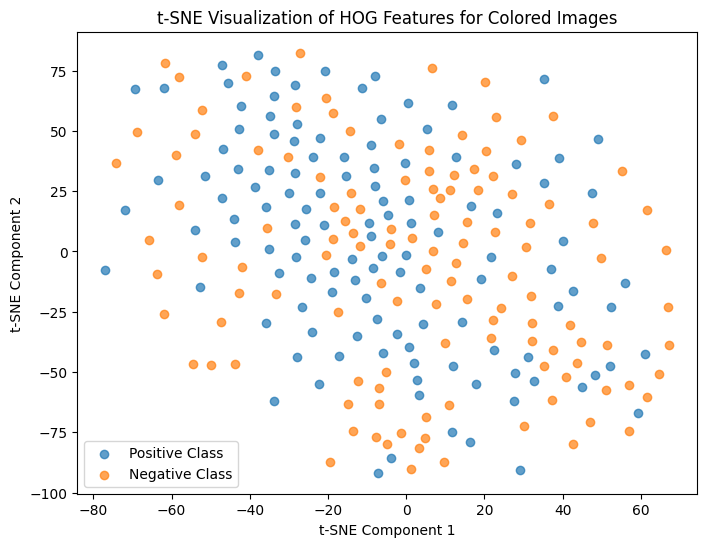

In [ ]:
# Perform t-SNE on HOG features
tsne_hog = TSNE(n_components=2, random_state=42)
tsne_result_hog = tsne_hog.fit_transform(all_hog_features)

# Plot the t-SNE representation for positive and negative labels
plt.figure(figsize=(8, 6))

# Plot positive class
plt.scatter(tsne_result_hog[all_labels == 1, 0], tsne_result_hog[all_labels == 1, 1], label='Positive Class', alpha=0.7)

# Plot negative class
plt.scatter(tsne_result_hog[all_labels == 0, 0], tsne_result_hog[all_labels == 0, 1], label='Negative Class', alpha=0.7)

plt.title('t-SNE Visualization of HOG Features for Colored Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2359b23e-ba82-4f61-a568-68ab2a2d2f2a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>